# ML test
### Testing of reading in data and trying an auto encoder

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
#import keras_tuner as kt
seed = tf.random.set_seed(1)

In [2]:
df = pd.read_hdf("/storage/shared/data/2lep_df_forML.hdf5")
df = pd.concat([df,pd.read_hdf("/storage/shared/data/2lep_df_forML_signal.hdf5")])


In [3]:
df.pop("category")
y = df["isSignal"]
df.pop("isSignal")
X = df
X = X.to_numpy()
y = y.to_numpy()


In [4]:
print(np.shape(X))
print(np.shape(y))

(109683372, 19)
(109683372,)


### Data handling and preperations
Before we train on the data, we need to scale it and split it into a validation and 

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [7]:
X_train, X_val, y_train, y_val= train_test_split(
                X, y, test_size=0.2, random_state=seed)

Now we need to separate the signal from the background in the training data.

In [8]:
X_back = X_train[np.where(y_train == 0)]

Then we perform a new split, such that we get a validation and training set for the autoencoder

In [9]:
X_b_train, X_b_val= train_test_split(
                X_back, test_size=0.2, random_state=seed)

In [53]:
data_shape = np.shape(X_b_train)[1]
number_of_rows = np.shape(X_b_train)[0]
n_vali = np.shape(X_b_val)[0]
random_indices = np.random.choice(number_of_rows, size=int(1e6), replace=False)

test_indices = np.random.choice(n_vali, size=int(200000), replace=False)

smaller_data = X_b_train[random_indices, :]
small_vali = X_b_val[test_indices, :]

### Training
Now we can train on the data

In [11]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


In [40]:
inputs = tf.keras.layers.Input(shape=data_shape, name="encoder_input")
x = tf.keras.layers.Dense(17, activation='relu')(inputs)
x1 = tf.keras.layers.Dense(13, activation='relu')(x)
x2 = tf.keras.layers.Dense(5, activation='relu')(x1)
encoder = tf.keras.Model(inputs, x2, name="encoder")

latent_input = tf.keras.layers.Input(shape=5, name="decoder_input")
x = tf.keras.layers.Dense(11, activation='relu')(latent_input)
x1 = tf.keras.layers.Dense(17, activation='relu')(x)
output = tf.keras.layers.Dense(data_shape, activation='relu')(x1)
decoder = tf.keras.Model(latent_input, output, name="decoder")

outputs = decoder(encoder(inputs))
AE_model = tf.keras.Model(inputs, outputs, name="AE_model")

optimizer = tf.keras.optimizers.Adam(1e-3)
AE_model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

In [41]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [54]:
with tf.device("/CPU:0"):
    AE_model.fit(smaller_data, smaller_data, batch_size=1000, epochs=50, validation_data=(small_vali,small_vali))
    
    print("Training done")
    recon_val = AE_model(X_val)
    print("Reconstruction done")
    
    err_val = tf.keras.losses.mse(recon_val, X_val).numpy()
    print("Test error done")

Epoch 1/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3889 - mse: 0.3889 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 2/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3889 - mse: 0.3889 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3889 - mse: 0.3889 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 4/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3889 - mse: 0.3889 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 5/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3889 - mse: 0.3889 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 6/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3889 - mse: 0.3889 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 7/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3889 - mse: 0.3889 - val_loss: 0.3889 - val_mse: 0.3889
Epoch 8/50
1000/1000 [==============================] - 8s 8ms

In [ ]:
#%tb

[2.16550547e-07 4.82968662e-07 1.55012461e-07 ... 1.03029711e-07
 3.14556306e-07 4.37413205e-07]
21936675


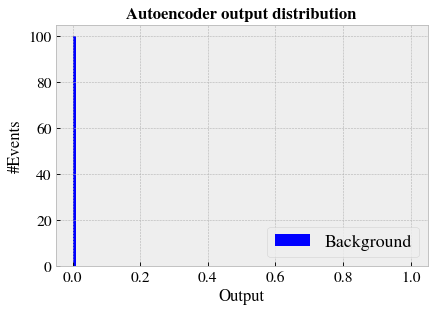

In [58]:
import plot_set
from plot_set import plot_histo

b = (err_val)#-np.min(err_val))/(np.max(err_val)-np.min(err_val))
print(b)

print(len(b))

plot_histo(b, "AE_histo.pdf")

In [46]:
AE_model.save("ex_model.h5")